# Set up Enviroment

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


# Load Data

In [3]:
# loading in count data
DM_count = ['DM_count_data']
data_dir_1 = '/data/DM1/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_1,var_names='gene_symbols',cache=True))
DM_count[1].var_names_make_unique(join='_')

data_dir_2 = '/data/DM2/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_2,var_names='gene_symbols',cache=True))
DM_count[2].var_names_make_unique(join='_')

data_dir_3 = '/data/DM3/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_3,var_names='gene_symbols',cache=True))
DM_count[3].var_names_make_unique(join='_')

data_dir_4 = '/data/DM4/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_4,var_names='gene_symbols',cache=True))
DM_count[4].var_names_make_unique(join='_')

data_dir_5 = '/data/DM5/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_5,var_names='gene_symbols',cache=True))
DM_count[5].var_names_make_unique(join='_')

for i in range(1,6):
    DM_count[i].obs['sample'] = 'DM'+str(i)

# user group label for each sample
DM_count[1].obs['user_group'] = 'MJ'
DM_count[2].obs['user_group'] = 'NONE'
DM_count[3].obs['user_group'] = 'MJ'
DM_count[4].obs['user_group'] = 'COC'
DM_count[5].obs['user_group'] = 'DUAL'

# dummy label for highlighting only one sample at a time in clustering maps
for i in range(1,6):
    dummy_var_name = 'sample'+str(i)+'_dummy'
    for j in range(1,6):
        if j==i:
            DM_count[j].obs[dummy_var_name] = 'DM'+str(j)
        else:
            DM_count[j].obs[dummy_var_name] = 'OTHERS'

# merging all the count objects into one object
combined = DM_count[1].concatenate(DM_count[i] for i in range(2,6))
combined

... reading from cache file cache/data-DM1-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM2-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM3-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM4-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM5-outs-filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 19155 × 33538
    obs: 'sample', 'user_group', 'sample1_dummy', 'sample2_dummy', 'sample3_dummy', 'sample4_dummy', 'sample5_dummy', 'batch'
    var: 'gene_ids', 'feature_types'

# QC Metrics

Compute and examine basic QC metrics before filtering

In [4]:
sc.pp.calculate_qc_metrics(combined, inplace=True)

In [5]:
# Check the computed metric names
# log1p: log(X+1) transform
combined

AnnData object with n_obs × n_vars = 19155 × 33538
    obs: 'sample', 'user_group', 'sample1_dummy', 'sample2_dummy', 'sample3_dummy', 'sample4_dummy', 'sample5_dummy', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Next compute metrics for mitochondrial genes and ribosomal genes

In [6]:
# Mitochondrial genes
mito_genes = combined.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
combined.obs['percent_mito'] = np.sum(combined[:, mito_genes].X, axis=1).A1 / np.sum(combined.X, axis=1).A1
# Ribosomal genes
ribo_genes = combined.var_names.str.startswith(("RPS","RPL"))
combined.obs['percent_ribo'] = np.sum(combined[:, ribo_genes].X, axis=1).A1 / np.sum(combined.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
combined.obs['n_counts'] = combined.X.sum(axis=1).A1

We should expect to see 13 mitochondrial genes being selected

In [7]:
print("The mitochodrial genes identified in the combined samples are:")
print(list(combined.var_names[mito_genes]))
print("There is a total of {} mitochondrial genes.".format(sum(mito_genes)))

The mitochodrial genes identified in the combined samples are:
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']
There is a total of 13 mitochondrial genes.


We should expect to see 104 ribosomal genes being selected

In [8]:
print("The ribosomal genes identified in the combined samples are:")
print(list(combined.var_names[ribo_genes]))
print("There is a total of {} mitochondrial genes.".format(sum(ribo_genes)))

The ribosomal genes identified in the combined samples are:
['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7', 'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29', 'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34', 'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10-NUDT3', 'RPS10', 'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS6KA2-AS1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPL36A', 'RPL36A-HNRNPH2', 'RPL39', 'RPL10', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6', 'RPL35', 'RPL12', 'RPL7A', 'RPLP2', 'RPL27A', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25', 'RPS24', 'RPS26', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPL10L', 'RPS29', 'RPL36AL', 'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPL4', 'RPLP1', 'RPS17', 'RPL3L', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23A', 'RPL23', 'RPL19', 'RPL27', 'RPS6KB1', 'RPL38', 'RPL17-C18orf32', 'RPL17', 'RPS21', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS16', 'RPS19', 'RPL18', 'RPL13A', 'RPS11'

... storing 'sample' as categorical
... storing 'user_group' as categorical
... storing 'sample1_dummy' as categorical
... storing 'sample2_dummy' as categorical
... storing 'sample3_dummy' as categorical
... storing 'sample4_dummy' as categorical
... storing 'sample5_dummy' as categorical
... storing 'feature_types' as categorical


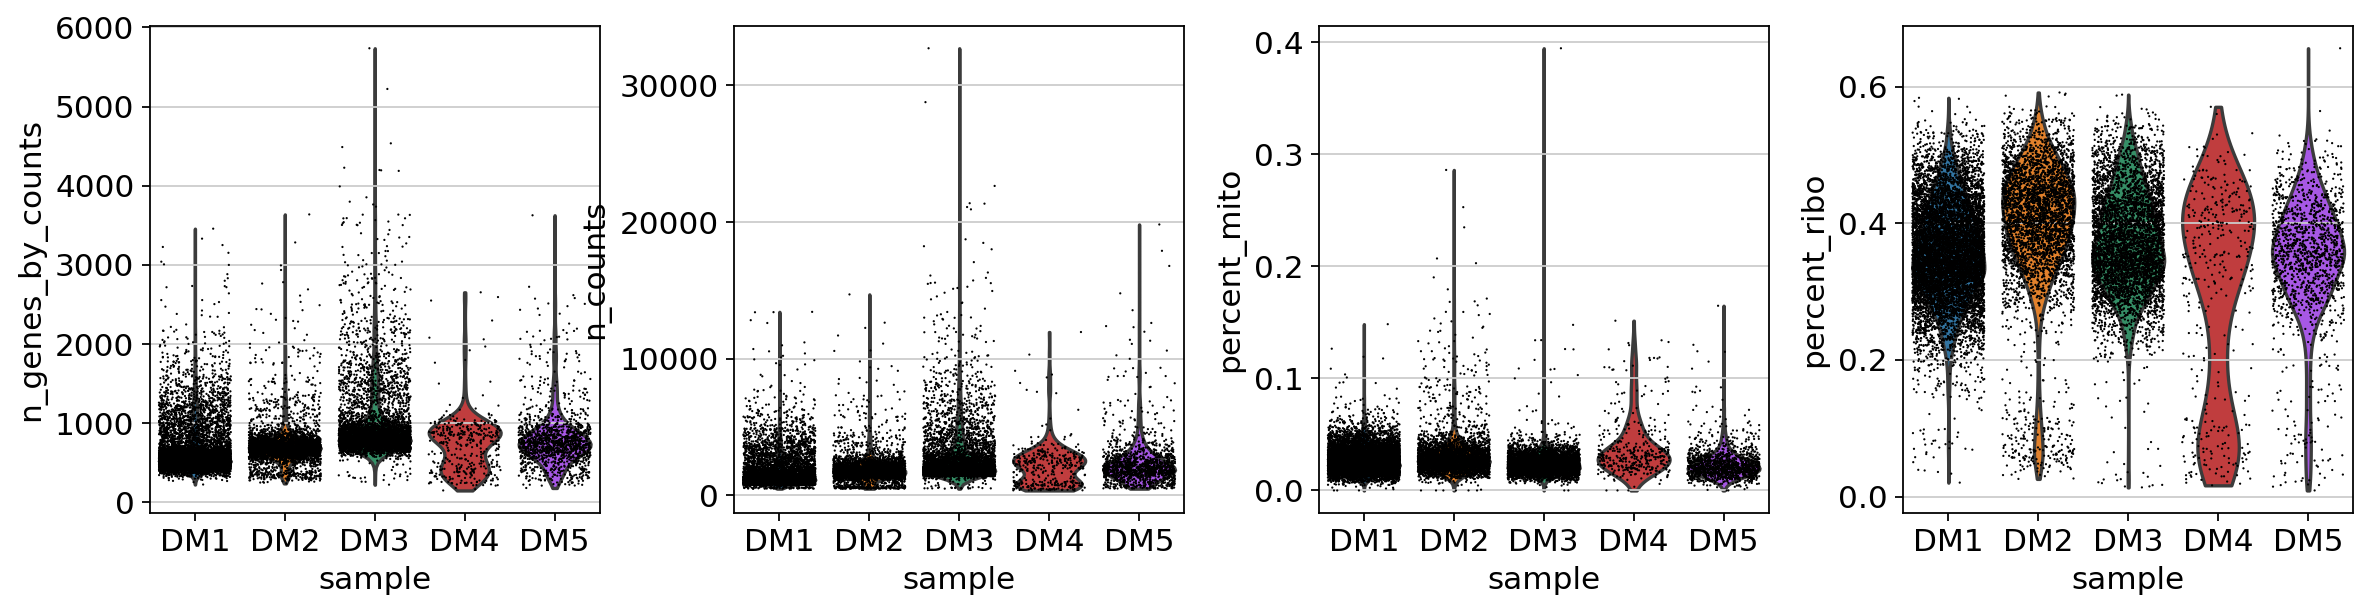

In [9]:
# Plotting QC metrics
# n_counts: total number of reads per cell
# n_genes_by_counts: the number mapped genes 
# percent_mito: percent of mitochondrial reads in total number of reads
# percent_ribo: percent of ribosomal reads in total number of reads
sc.pl.violin(combined, ['n_genes_by_counts','n_counts','percent_mito','percent_ribo'], jitter=0.4, groupby='sample')

In [10]:
print("The number of cells and genes before filtering: {},{}".format(combined.n_obs, combined.n_vars))

The number of cells and genes before filtering: 19155,33538


# QC Filter

## Preliminary Filtering

Filtering out genes expressed in less than 3 cells (not useful for statistical analysis due to effect of random error) and cells that have less than 200 expressed genes (broken cells for sure). 

In [11]:
sc.pp.filter_cells(combined, min_genes=200)
sc.pp.filter_genes(combined, min_cells=3)
print("The number of cells and genes left: {},{}".format(combined.n_obs, combined.n_vars))

filtered out 4 cells that have less than 200 genes expressed
filtered out 15369 genes that are detected in less than 3 cells
The number of cells and genes left: 19151,18169


## Cell Filtering Based on QC Violin Plots

We then filter out the cells that have too many genes detected (doublet). Based on the above violin plt for n_genes_by_counts, the thresholds for DM1-DM5 should be  1100, 1400, 1600, 1600, 1500 (basically twice the average which can be eyeballed around the belly of the violin) respectively. 

In [12]:
# filter for DM1
keep_DM1 = (combined.obs['n_genes_by_counts'] < 1100) & (combined.obs['sample'] == 'DM1')
print("Cells left in DM1: "+str(sum(keep_DM1)))
# filter for DM2
keep_DM2 = (combined.obs['n_genes_by_counts'] < 1400) &(combined.obs['sample'] == 'DM2')
print("Cells left in DM2: "+str(sum(keep_DM2)))
# filter for DM3
keep_DM3 = (combined.obs['n_genes_by_counts'] < 1600) & (combined.obs['sample'] == 'DM3')
print("Cells left in DM3: "+str(sum(keep_DM3)))
# filter for DM4
keep_DM4 = (combined.obs['n_genes_by_counts'] < 1600)  &(combined.obs['sample'] == 'DM4')
print("Cells left in DM4: "+str(sum(keep_DM4)))
# filter for DM4
keep_DM5 = (combined.obs['n_genes_by_counts'] < 1500) &(combined.obs['sample'] == 'DM5')
print("Cells left in DM2: "+str(sum(keep_DM5)))

Cells left in DM1: 7916
Cells left in DM2: 3740
Cells left in DM3: 4424
Cells left in DM4: 374
Cells left in DM2: 1296


Combine the kept cells again

In [13]:
keep = (keep_DM1) | (keep_DM2) | (keep_DM3)| (keep_DM4)| (keep_DM5)
combined = combined[keep, :]

print("Total remaining cells %d"%combined.n_obs)

Total remaining cells 17750


Filtering out cells with too high mitochondrial percentage or too low ribosomal genes percentage

In [14]:
# filter for high percent mito
combined = combined[combined.obs['percent_mito'] < 0.06, :]

# filter for high percent ribo > 0.05
combined = combined[combined.obs['percent_ribo'] > 0.15, :]

print("Total remaining cells %d"%combined.n_obs)

Total remaining cells 17187


Plot filtered QC

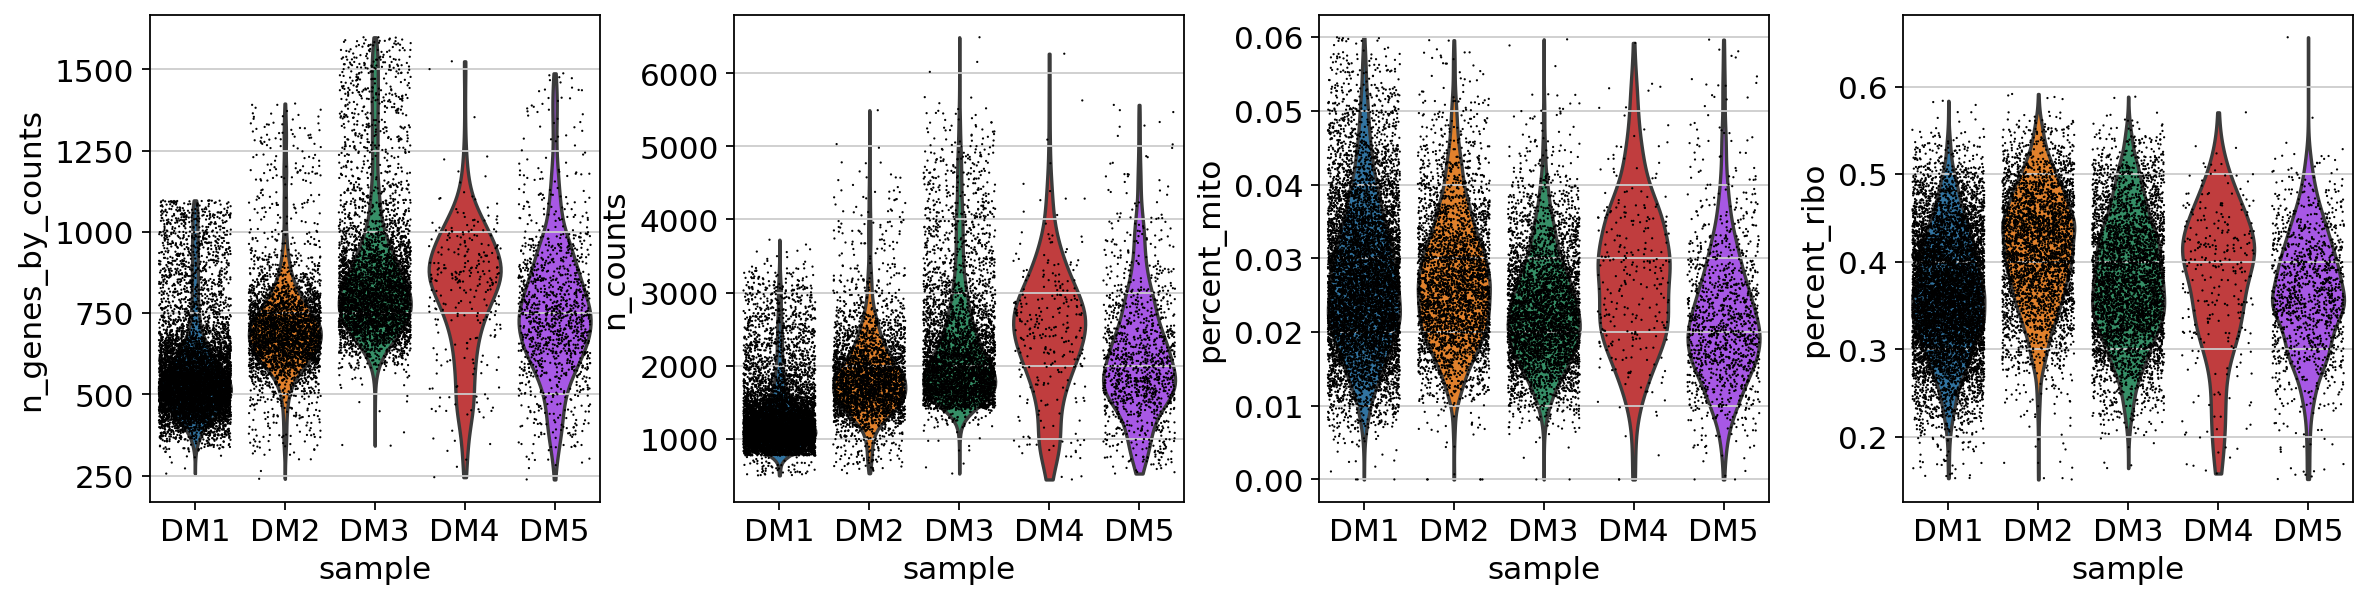

In [15]:
sc.pl.violin(combined, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],jitter=0.4, groupby = 'sample')

## Gene Filtering 

First take a look at the gene expression levels

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


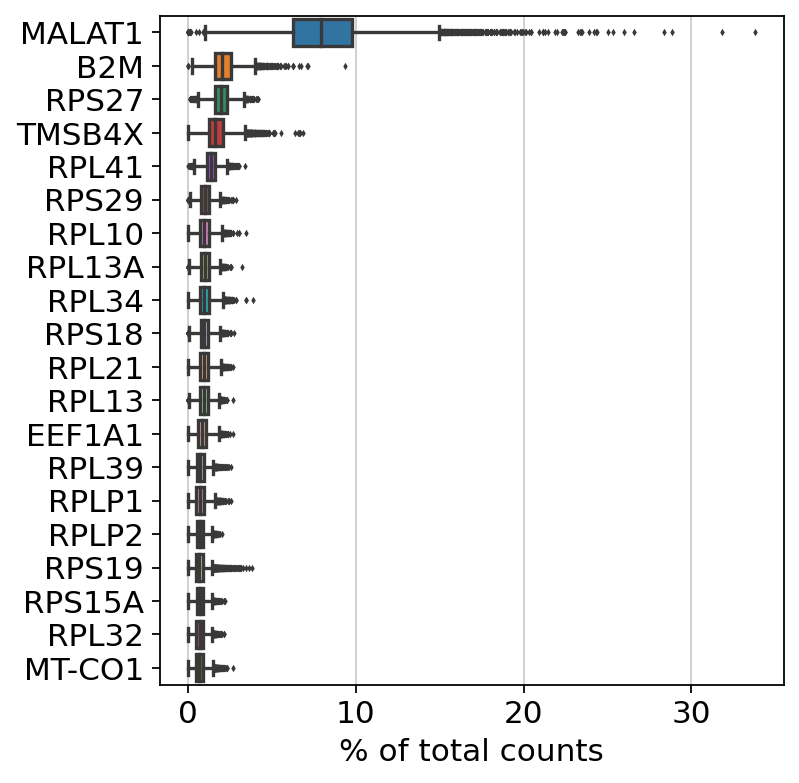

In [16]:
sc.pl.highest_expr_genes(combined, n_top=20)

A few things we can see:
(1) MALAT1 is the highest
(2) top genes are almost all ribosomal or mitochondrial

As the level of expression of MALAT1 genes are much much higher (which goes up to 34%) than that of the rest genes, we do wish to them from the dataset to before we encounter technical issues in further steps (due to normalization). We also remove mitochondrial genes which only concern dead/dying cells, and ribosomal genes which could create batch effects. There are other ways how these genes can affect downstream analysis results as well. However, before actually removing them, we do a careful check to make sure that these genes don't correpond to a lot of biological significance for samples

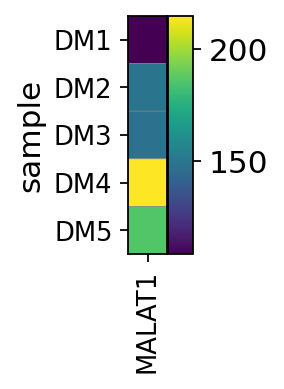

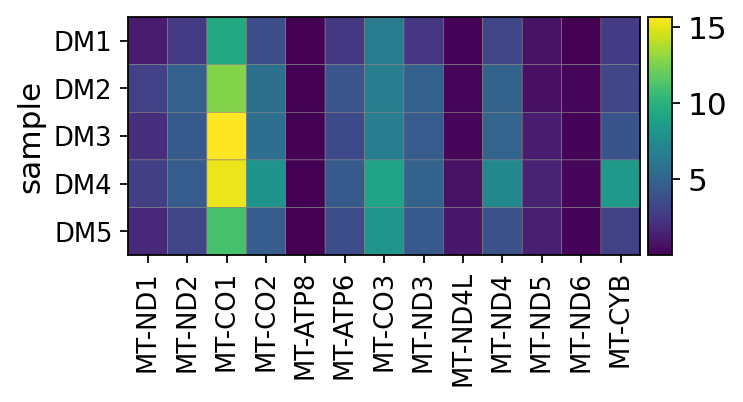

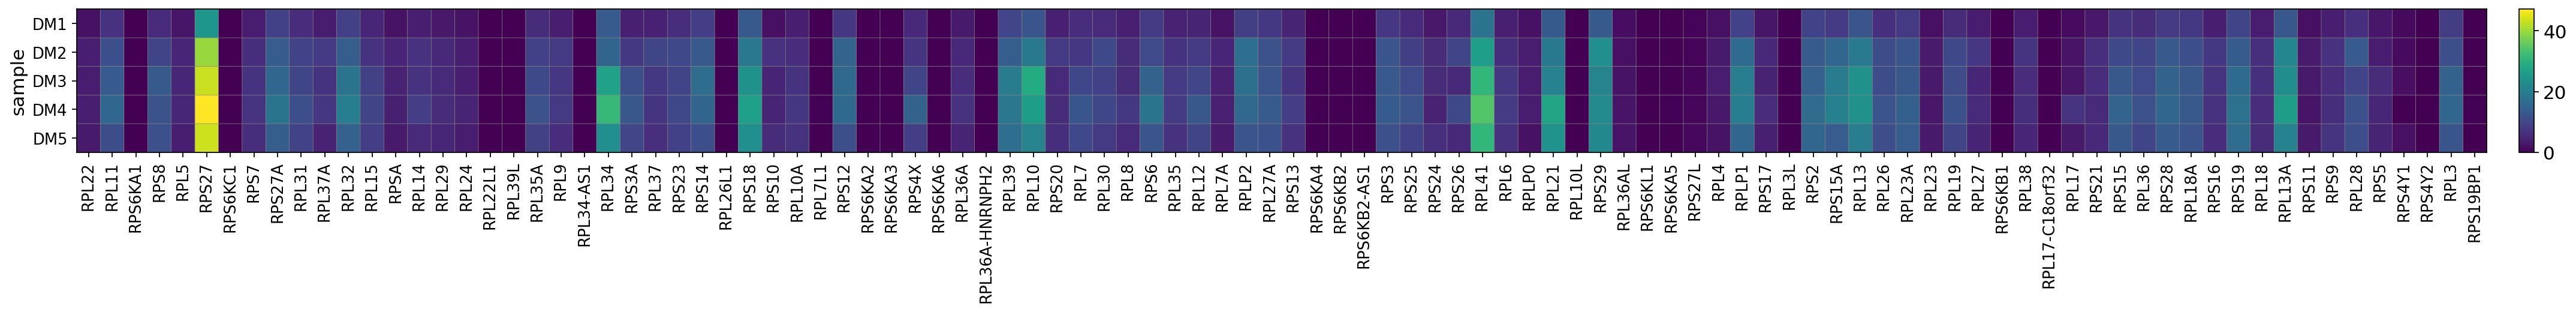

GridSpec(2, 3, height_ratios=[0, 10.5], width_ratios=[32.64, 0, 0.2])

In [17]:
# Look at the distribution of ribosomal genes and mitochondrial genes
 # since some genes have been filtered, we need to reselect mito and ribo from the remaining genes
ribo_genes = combined.var_names.str.startswith(("RPS","RPL"))
mito_genes = combined.var_names.str.startswith('MT-')
malat1 = combined.var_names.str.startswith('MALAT1')

sc.pl.matrixplot(combined, list(combined.var_names[malat1]), groupby='sample')
sc.pl.matrixplot(combined, list(combined.var_names[mito_genes]), groupby='sample')
sc.pl.matrixplot(combined, list(combined.var_names[ribo_genes]), groupby='sample')

The color scale shows mean expression level for all cells in the group (here we group by samples). It seems that all ribosomal and mitochondrial genes expression levels are not differentiable (either all high or all low) so we can safely filter them out. 

However, for MALAT1, the story is very different. First of all, MALAT1 is non-coding and should safely reside in nucleau without being picked up. But in fact, for 10X single cell sequencing assays, it is very common that MALAT1 has a high percentage. Here is the explanation given in 10X website:

"Malat1 is frequently detected in poly-A captured RNA-seq data, independent of protocol. The level of detection appears to be cell type-specific and also shows some inverse correlation with cell health. We have observed that dead/dying cells have higher expression of Malat1."

For now, we go ahead filtering them out to see how the downstream analysis look. And if needed, we definitely should add MALAT1 back for some analysis because it seems highly variable in samples and do have some biological significance (see https://www.sciencedirect.com/science/article/pii/S2211124712001635)

In [18]:
remove = np.add(ribo_genes,mito_genes)
remove = np.add(remove,malat1)
keep = np.invert(remove)
combined = combined[:,keep]

print("The number of cells and genes left: {},{}".format(combined.n_obs, combined.n_vars))

The number of cells and genes left: 17187,18053


Now look at the gene expression levels again

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


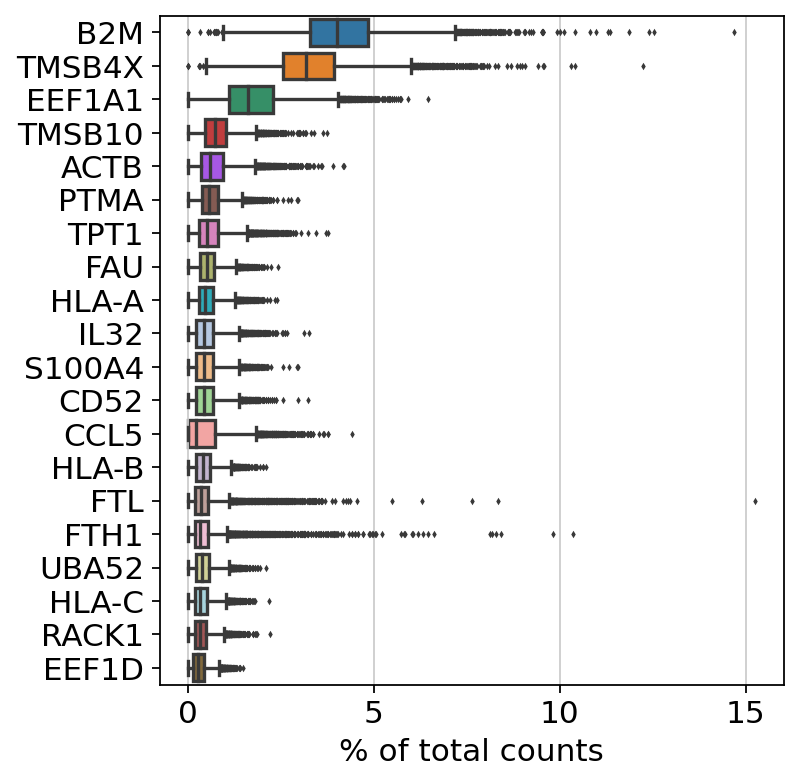

In [19]:
sc.pl.highest_expr_genes(combined, n_top=20)

In [20]:
save_file = '/scratch/qc_filtered_combined_samples.h5ad'
combined.write_h5ad(save_file)